In [1]:
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1

Writing requirements.txt


In [2]:
!pip install -r requirements.txt
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have

In [3]:
import keras_cv
import numpy as np
import os
import tensorflow as tf
import keras as tfk      
from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl
from keras.utils import to_categorical
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn as scikit_learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

seed = 42

print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

2024-11-19 16:50:27.344889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 16:50:27.367164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 16:50:27.373964: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version -> 2.17.0
Keras version -> 3.4.1


# Help Functions

In [42]:
#Given a labels dataset, returns a dictionary with the class sample counts
def count_classes(labels):
 
    # Se le etichette sono codificate one-hot, convertili a indici
    if isinstance(labels, np.ndarray) and len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)
    
    # Usa numpy per contare le occorrenze di ogni classe
    unique_classes, counts = np.unique(labels, return_counts=True)
    
    # Crea un dizionario per restituire il conteggio
    class_counts = {cls: count for cls, count in zip(unique_classes, counts)}
    return class_counts

def plot_confusion_matrix(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(cm)))
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()


# Load and duplicate Data

In [5]:
#This time we work on Kagge
#Load the dataset from the .npz file and take "images" and "labels"
data = np.load('/kaggle/input/dataset/training_set_without_outlier.npz') # or 'datsetWithout.npz'

images = data['images']
labels = data['labels'] 
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

#show the amout of samples for each class
classes = count_classes(labels.flatten())
print(classes)

## We duplicate the first 800 images for the class 0,2,4,5
quantity = 800
class_to_duplicate = [0,2,4,5]
for i in class_to_duplicate:
    class_N_indices = np.where(labels.flatten() == i)[0]
    images_N = images[class_N_indices][:quantity]
    labels_N = labels[class_N_indices][:quantity]
    images = np.concatenate([images, images_N], axis=0)
    labels = np.concatenate([labels, labels_N], axis=0)

#show the amout of samples for each class after the duplication
classes = count_classes(labels.flatten())
print(classes)

#Initial shuffle of the data
indices = np.random.permutation(len(images))
shuffled_images = images[indices]
shuffled_labels = labels[indices]

#Free some memory
del data
del images
del labels

Images shape: (11959, 96, 96, 3)
Labels shape: (11959, 1)
{0: 852, 1: 2181, 2: 1085, 3: 2026, 4: 849, 5: 993, 6: 2330, 7: 1643}
{0: 1652, 1: 2181, 2: 1885, 3: 2026, 4: 1649, 5: 1793, 6: 2330, 7: 1643}


In [6]:
#Normalization of images and categorical format for labels
normalized_images = shuffled_images / 255.0
categorical_labels = to_categorical(shuffled_labels).astype('float32')

#Free some memory
del shuffled_images 
del shuffled_labels

In [7]:
#Split data into Training set and Validation set
X_train, X_val, y_train, y_val = train_test_split(normalized_images, categorical_labels, test_size=0.2, stratify=categorical_labels)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(12127, 96, 96, 3)
(3032, 96, 96, 3)
(12127, 8)
(3032, 8)


# Augmentation

In [8]:
# Heavy augmentation for validation set
data_augmentation_val = tfk.Sequential(
[
    keras_cv.layers.RandomAugmentationPipeline(
    layers=[
        keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
        keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
        keras_cv.layers.RandomContrast(factor=0.8, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomHue(factor=(0.8,1.0), value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomSharpness(factor = 1, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomColorDegeneration(factor = 1, seed=seed),
        keras_cv.layers.ChannelShuffle(groups=3, seed=seed),
        keras_cv.layers.RandomChannelShift(factor=0.8, value_range=(0.0, 1.0), channels=3, seed=seed),
        keras_cv.layers.Solarization(value_range = (0.0, 1.0), seed=seed),
        keras_cv.layers.RandomBrightness(factor=0.3, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.GridMask(ratio_factor=(0, 0.4), rotation_factor=0.2, fill_mode="constant", fill_value=0.0, seed=seed)
    ],
    seed=seed,
    augmentations_per_image=3
)
])


# Usual augmentation for training set
data_augmentation_tr = tfk.Sequential(
[
    keras_cv.layers.RandAugment(
        value_range=(0.0, 1.0),
        augmentations_per_image=4,
        magnitude_stddev=0.4, 
        rate=0.5
    )
])


I0000 00:00:1732035039.533044      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732035039.544435      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732035039.544731      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732035039.546736      30 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

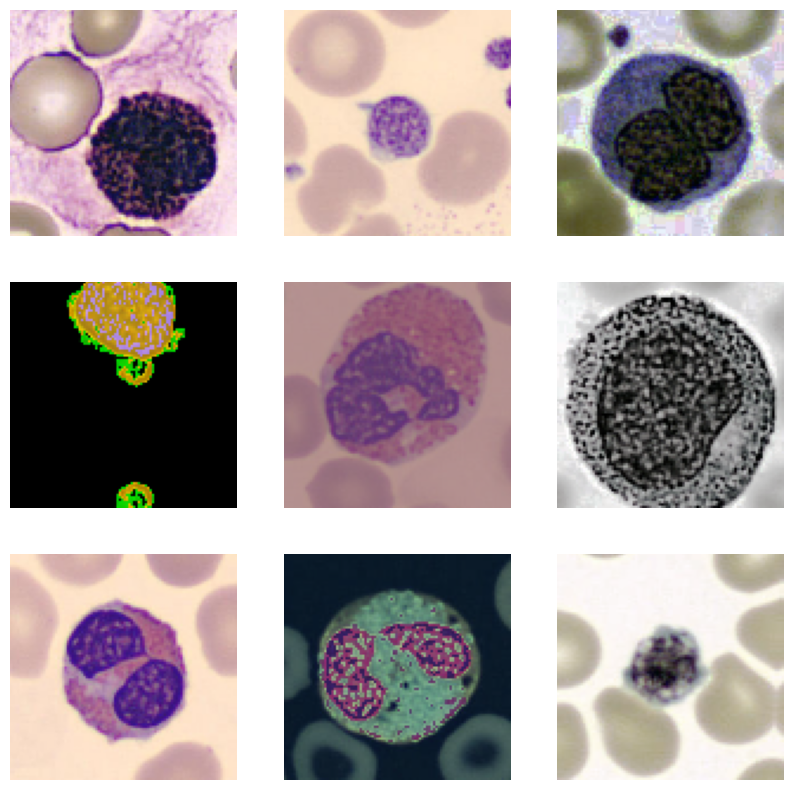

In [9]:
#Try to augment a portion of the X_train images
image_portion = X_train[:10]
image_portion = data_augmentation_tr(image_portion)

#Plot the augmentations
plt.figure(figsize=(10, 10))
for i in range(9):
   plt.subplot(3, 3, i + 1)
   plt.imshow(image_portion[i]) 
   plt.axis("off")
plt.show()

In [10]:
#Convert the data into a more suitable format that speeds up the augmentation a lot
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(512)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(512)

In [11]:
#wrapper fucntion for the augmentation of training set
def augment_images_tr(image, label):
    image = data_augmentation_tr(image)  # Apply data augmentation to the image
    return image, label  # Return the augmented image and the unchanged label

#wrapper fucntion for the augmentation of validation set
def augment_images_val(image, label):
    image = data_augmentation_val(image)  # Apply data augmentation to the image
    return image, label  # Return the augmented image and the unchanged label

# Apply the mapping to both Train and Validation sets
train_dataset = train_dataset.map(augment_images_tr, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(augment_images_val, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [12]:
# Reconvert the Training and Validation set into numpy arrays
X_train, y_train = [], []
for batch in train_dataset:
    images = batch[0].numpy()
    labels = batch[1].numpy()
    X_train.append(images)
    y_train.append(labels)
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

del train_dataset

# Convert validation dataset to numpy arrays
X_val, y_val = [], []
for batch in val_dataset:
    images = batch[0].numpy()
    labels = batch[1].numpy()
    X_val.append(images)
    y_val.append(labels)
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

del val_dataset

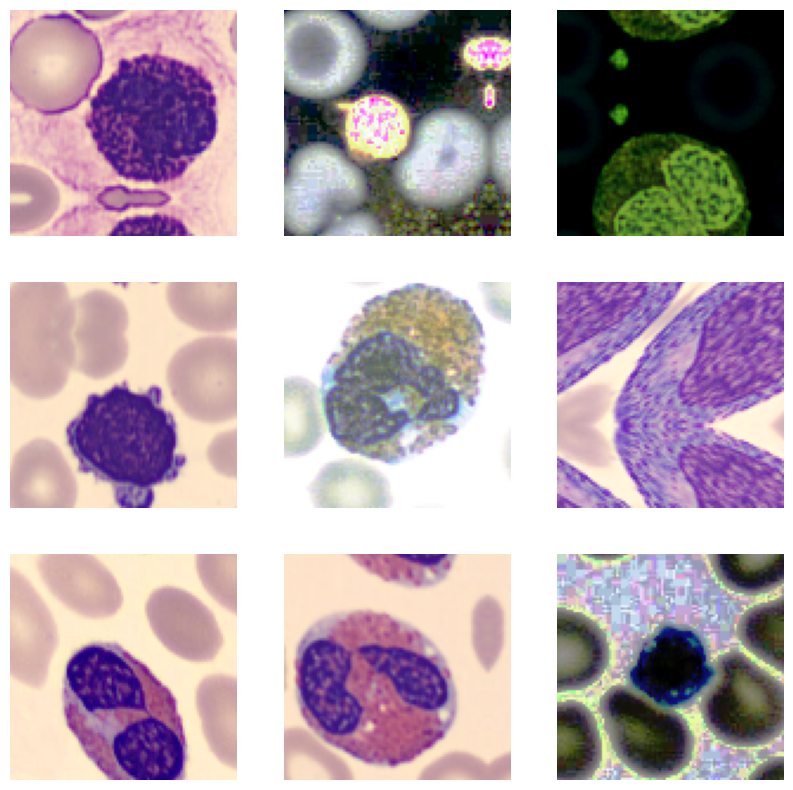

In [13]:
#Debug the augmentation process
image_portion = X_train[:10]

# Shows the 9 images of X_train after augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
   plt.subplot(3, 3, i + 1)
   plt.imshow(image_portion[i]) 
   plt.axis("off")
plt.show()

# Transfer Learning from ConvNeXtBase

In [14]:
net_name = "convnext_base"

In [15]:
input_shape = (96, 96, 3)
output_shape = 8
learning_rate = 0.005
batch_size = 64
epochs = 1000


# Initialise ConvNeXtBase model with pretrained weights
ext_net = tfk.applications.ConvNeXtBase(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg',
    include_preprocessing=True
)

# Display a summary of the model architecture
ext_net.summary(expand_nested=True)

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "convnext_base"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_pres… │ (None, 96, 96, 3) │          0 │ input_layer_2[0]… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stem  │ (None, 24, 24,    │      6,528 │ convnext_base_pr… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 24, 24,    │      6,272 │ -                 │
│ convnext_base_stem… │ 128)              │            │                   │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 24, 24,    │        256 │ -                 │
│ convnext_base_stem… │ 128)              │            │                   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │      6,400 │ convnext_base_st… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │        128 │ convnext_base_st… │
│ (LayerScale)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │          0 │ convnext_base_st… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ convnext_base_st… │
│                     │ 128)              │            │ convnext_base_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │      6,400 │ add[0][0]         │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                 

 Total params: 87,566,464 (334.04 MB)

 Trainable params: 87,566,464 (334.04 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Freeze all layers in ConvNeXtBase, first we train only the classification head
ext_net.trainable = False

inputs = tfk.Input(shape=input_shape, name='input_layer')

x = ext_net(inputs)
x = tfkl.Dropout(0.3, name='dropout')(x)
x = tfkl.Dense(256, name='dense1')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Activation("relu")(x)

x = tfkl.Dropout(0.5, name='dropout1')(x)
outputs = tfkl.Dense(output_shape, activation='softmax', name='dense2')(x)

tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

tl_model.summary(expand_nested=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 1024)           │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_2 (InputLayer) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 96, 96, 3)      │             0 │
│ convnext_base_prestem_normaliz… │                        │               │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ convnext_base_stem         │ (None, 24, 24, 128)    │         6,528 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ convnext_base_stem_conv │ (None, 24, 24, 128)    │         6,272 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └                         │ (None, 24, 24, 128)    │           256 │
│ convnext_base_stem_layernorm    │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │         6,400 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │           256 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 512)    │        66,048 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 512)    │             0 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │        65,664 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │           128 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (LayerScale)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │             0 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │         6,40

 Total params: 87,831,944 (335.05 MB)

 Trainable params: 264,968 (1.01 MB)

 Non-trainable params: 87,566,976 (334.04 MB)

# Early Stopping

In [20]:
# Define the patience value for early stopping
patience = 40

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

# Train classification head

In [21]:
history = tl_model.fit(
    x=X_train*255,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(X_val*255, y_val),
    callbacks=callbacks
).history

Epoch 1/1000


I0000 00:00:1732035376.638329     105 service.cc:146] XLA service 0x558953104c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732035376.638368     105 service.cc:154]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/190 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.0742 - loss: 3.0531   

I0000 00:00:1732035383.520845     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


190/190 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.5422 - loss: 1.3323 - val_accuracy: 0.6728 - val_loss: 0.9230
Epoch 2/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.7706 - loss: 0.6701 - val_accuracy: 0.7051 - val_loss: 0.8321
Epoch 3/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.7956 - loss: 0.5855 - val_accuracy: 0.7226 - val_loss: 0.7877
Epoch 4/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.8075 - loss: 0.5409 - val_accuracy: 0.7338 - val_loss: 0.7824
Epoch 5/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.8265 - loss: 0.4945 - val_accuracy: 0.7355 - val_loss: 0.7672
Epoch 6/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.8313 - loss: 0.4776 - val_accuracy: 0.7322 - val_loss: 0.7832
Epoch 7/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.8318 - loss: 0.4741 - val_accuracy: 0.7398 - val_loss: 0.7626
Epoch 8/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.8456 - loss: 0.444

In [22]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Final validation accuracy: 76.39%


In [23]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

8

95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step


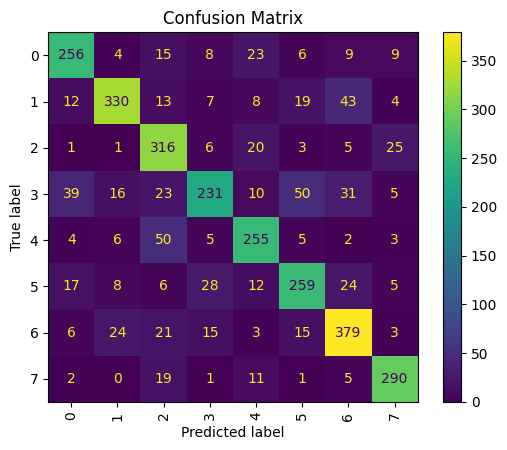

In [44]:
#Print confusion matrix on the validation set
plot_confusion_matrix(tl_model, X_val*255, y_val)

In [27]:
#Save the weight of the head
tl_model.save('weights_head.keras')
del tl_model

# Define Fine Tuning network

In [28]:
ft_model = tfk.models.load_model('weights_head.keras')
# Set the ConvNeXtBase model layers as trainable
ft_model.get_layer(net_name).trainable = True

# Set all MobileNetV3Small layers as non-trainable
for layer in ft_model.get_layer(net_name).layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer(net_name).layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

3 convnext_base_stage_0_block_0_depthwise_conv Conv2D True
10 convnext_base_stage_0_block_1_depthwise_conv Conv2D True
17 convnext_base_stage_0_block_2_depthwise_conv Conv2D True
25 convnext_base_stage_1_block_0_depthwise_conv Conv2D True
32 convnext_base_stage_1_block_1_depthwise_conv Conv2D True
39 convnext_base_stage_1_block_2_depthwise_conv Conv2D True
47 convnext_base_stage_2_block_0_depthwise_conv Conv2D True
54 convnext_base_stage_2_block_1_depthwise_conv Conv2D True
61 convnext_base_stage_2_block_2_depthwise_conv Conv2D True
68 convnext_base_stage_2_block_3_depthwise_conv Conv2D True
75 convnext_base_stage_2_block_4_depthwise_conv Conv2D True
82 convnext_base_stage_2_block_5_depthwise_conv Conv2D True
89 convnext_base_stage_2_block_6_depthwise_conv Conv2D True
96 convnext_base_stage_2_block_7_depthwise_conv Conv2D True
103 convnext_base_stage_2_block_8_depthwise_conv Conv2D True
110 convnext_base_stage_2_block_9_depthwise_conv Conv2D True
117 convnext_base_stage_2_block_10_dept

In [29]:
# Set the number of layers to freeze
N = 15 #We freeze only the first initial layers

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer(net_name).layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer(net_name).layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)


0 input_layer_2 False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 convnext_base_stage_0_block_1_depthwise_conv False
11 convnext_base_stage_0_block_1_layernorm False
12 convnext_base_stage_0_block_1_pointwise_conv_1 False
13 convnext_base_stage_0_block_1_gelu False
14 convnext_base_stage_0_block_1_pointwise_conv_2 False
15 convnext_base_stage_0_block_1_layer_scale False
16 convnext_base_stage_0_block_1_identity False
17 convnext_base_stage_0_block_2_depthwise_conv True
18 convnext_base_stage_0_block_2_layernorm False
19 convnext_base_stage_0_block_2_pointwise_conv_1 False
20 convnext_base_stage_0_block_2_gelu Fa

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 1024)           │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_2 (InputLayer) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 96, 96, 3)      │             0 │
│ convnext_base_prestem_normaliz… │                        │               │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ convnext_base_stem         │ (None, 24, 24, 128)    │         6,528 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ convnext_base_stem_conv │ (None, 24, 24, 128)    │         6,272 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └                         │ (None, 24, 24, 128)    │           256 │
│ convnext_base_stem_layernorm    │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │         6,400 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │           256 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 512)    │        66,048 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 512)    │             0 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │        65,664 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │           128 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (LayerScale)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │             0 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │         6,40

 Total params: 88,361,882 (337.07 MB)

 Trainable params: 1,154,568 (4.40 MB)

 Non-trainable params: 86,677,376 (330.65 MB)

 Optimizer params: 529,938 (2.02 MB)

In [30]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

# Early Stopping

In [31]:
# Define the patience value for early stopping
patience = 15 

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

# Train Fine Tuning Network

In [32]:
# Fine-tune the model
ft_history = ft_model.fit(
    x=X_train*255,
    y=y_train,
    batch_size = batch_size,
    epochs=130,
    validation_data=(X_val*255, y_val),
    callbacks=callbacks
).history


Epoch 1/130


E0000 00:00:1732037520.674158     108 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732037520.855247     108 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


189/190 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9079 - loss: 0.2529

E0000 00:00:1732037566.423440     107 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732037566.604405     107 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


190/190 ━━━━━━━━━━━━━━━━━━━━ 90s 302ms/step - accuracy: 0.9080 - loss: 0.2527 - val_accuracy: 0.7803 - val_loss: 0.6701
Epoch 2/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - accuracy: 0.9355 - loss: 0.1848 - val_accuracy: 0.7906 - val_loss: 0.6460
Epoch 3/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - accuracy: 0.9490 - loss: 0.1502 - val_accuracy: 0.8024 - val_loss: 0.6164
Epoch 4/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - accuracy: 0.9516 - loss: 0.1351 - val_accuracy: 0.8071 - val_loss: 0.5982
Epoch 5/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - accuracy: 0.9672 - loss: 0.1073 - val_accuracy: 0.8074 - val_loss: 0.5964
Epoch 6/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - accuracy: 0.9745 - loss: 0.0892 - val_accuracy: 0.8120 - val_loss: 0.5901
Epoch 7/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.9777 - loss: 0.0787 - val_accuracy: 0.8100 - val_loss: 0.5955
Epoch 8/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.9802 - loss: 0.071

In [38]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Final validation accuracy: 83.87%


95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


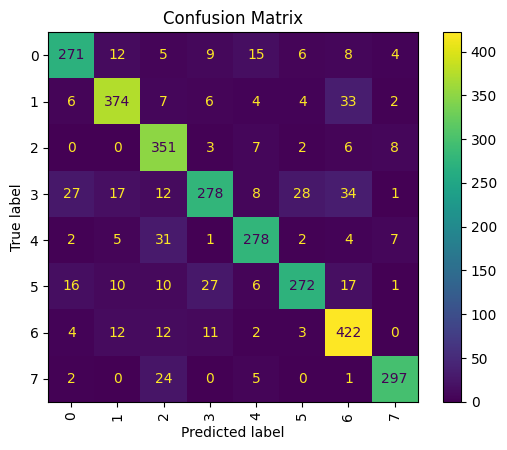

In [45]:
#Print confusion matrix on the validation set
plot_confusion_matrix(ft_model, X_val*255, y_val)

In [46]:
#Save the weights of the whole network
ft_model.save('weights.keras')

# Submission

In [47]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must not be one-hot
        encoded.

        We do not need /255 as the network has a preprocessing layer inside.
        """

        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
           preds = np.argmax(preds, axis=1)
        return preds



Overwriting model.py


In [48]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: model.py (deflated 53%)
  adding: weights.keras (deflated 8%)
